### mm_elecRep

This notebook generates a report for an electrode contact. Loads data for a particular cluster. Selects a specific contact. Plots the following:

[x] single trial ephys examples (spanning cue)

[x] ERP (spanning cue)

[x] power spectrum pre and post-cue 

[x] FOOOF fits pre and post cue

[X]  Normalized (within event_type) power

[X] (within electrode) PLV over time for 3 Hz, 8 Hz, 12-30 Hz

[X] pair-wise PLV for all other electrodes within this cluster vs cluster 1 (only theta)


# Code TO DO:
[X] Implement freq_ranges in electrode class function calls
[X] Export Electrode Class to mm_func
[X] delete general PLV and FOOF functions from mm_func




In [1]:
# import packages
import numpy as np # numpy
import pandas as pd # pandas
from scipy import stats
import mm_func
import mne
import pycircstat as circ
from mne import time_frequency
from fooof import FOOOF
from pylab import * 
%matplotlib inline
import os


In [2]:
# define parameters for analyses as a dictionary
params = {'clusId':3,'rejection_thresh_sd':20,
          'event_type':'move',
          'time_window_ms':(-500,500),
          'time_window_ms_pre':(-1200,0),
          'time_window_ms_pst':(0,1200),
          'time_window_ms_pre_plv':(-500,-100),
          'time_window_ms_pst_plv':(100,500),
          'buffer_ms_erp':0,
         'frange':(2,40),
         'bg_param':'knee',
          'HFA_range':(70,120),
          'theta_range':(3,8),
          'alpha_range':(10,12),
          'beta_range':(12,30),
          'gamma_range':(30,40),
         'time_window_ms_wave':(-1800,1800),
         'buffer_ms_wave':1000,
         'frange_wave':(3,120),
         'numfreqs_wave':15} 
# fig path
figpath = '/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/motormap/figs/elecRep/evType-'+str(params['event_type'])+'/cluster'+str(params['clusId'])+'/'
print(figpath)

# make directory if it doesnt exist
if os.path.exists(figpath) == False:
    os.makedirs(figpath)

/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/motormap/figs/elecRep/evType-move/cluster3/


In [3]:
#load data
#load data from a cluster
[EEG,metadata] = mm_func.loadEEG(clusId=params['clusId'])


/Users/ashwinramayya/Dropbox/neurosurgery_research/data/scratch/clusStruct/pac/
/Users/ashwinramayya/Dropbox/neurosurgery_research/data/scratch/clusStruct/pac/pacClusStruct-3.mat
dict_keys(['__header__', '__version__', '__globals__', 'eegStruct_thisClus'])
Number of contacts in Cluster 3 = 46
REPLACING Contact 13 field anat with NONE
Done loading Cluster 3


In [4]:
def plotPSDSummary_local(E,params):
    """This is a local function to plot a summary of the PSD change pre and post cue around each electrode
    Inputs:
    E ... instance of electrode class 
    params... params dictionary """
    
    #initialize  figure
    fig = figure(figsize=[10,10])
    fig.suptitle(E.metadata['uElbl'].iloc[0]+'  '+E.metadata['ROI'].iloc[0],fontsize=16,x=0.25)
    C = cm.get_cmap('tab10')

    # get EEG (ERP)
    E.getEEG(params['event_type'],
                    params['time_window_ms'],
                   params['buffer_ms_erp'],
                   params['rejection_thresh_sd'])

    # plot single trial ERP
    E.plotSingleTrial(10,ax=subplot(321))
    E.plotERP(ax=subplot(322))


    # Plot PSD (pre)
    # update EEG with new time window
    E.getEEG(time_window_ms=
                    params['time_window_ms_pre'])
    E.calcPSD(params['frange'])
    E.plotPSD(ax=subplot(323))
    E.fitFOOOF()
    E.plotFOOOF_params(subplot(324),kol=C.colors[0])
    E.plotFOOOF_fits(subplot(325))


    # update EEG with new time window
    E.getEEG(time_window_ms=
                    params['time_window_ms_pst'])
    E.calcPSD(params['frange'])
    E.plotPSD(ax=subplot(323))
    E.fitFOOOF()
    E.plotFOOOF_params(subplot(324),kol=C.colors[1])
    E.plotFOOOF_fits(subplot(326))
    
    # title for PSD
    ax = subplot(323)
    ax.text(18,ax.get_ylim()[1]-0.5,'Pre '+str(params['time_window_ms_pre'])+' vs. Post '+str(params['time_window_ms_pst']),fontsize=10)

        

In [5]:
#Time frequency analysis
def plotTFSummary_local(E,params):

    # Inititalize figure
    fig = figure(figsize = [15,30])

    # get eeg (using wavelet parameters)
    E.getEEG(params['event_type'],
                        params['time_window_ms_wave'],
                       params['buffer_ms_wave'],
                      params['rejection_thresh_sd'])

    # calc power
    E.calcPow(params['buffer_ms_wave'],params['frange_wave'],params['numfreqs_wave'])

    # plot z-power
    E.plotZPowMat(subplot(621))
    ax = gca()
    ax.set_title(E.metadata['uElbl'].iloc[0]+'  '+E.metadata['ROI'].iloc[0],fontsize=16,x=0.25)

    # plot z-pow vec
    E.plotZPowVec(subplot(622))

    # calc phase
    E.calcPhase(params['buffer_ms_wave'],params['frange_wave'],params['numfreqs_wave'])

    # Theta PLV 
    #calc PLV over time
    E.calcPLV_over_time(params['theta_range'])
    E.plotPLV_over_time(subplot(623))

    # calc PLV polar in time win of max Z
    E.calcPLV(params['theta_range'],E.PLVot_maxZ_time_win)
    E.plotPLV_polar(subplot(624,polar = True))


    # alpha PLV 
    #calc PLV over time
    E.calcPLV_over_time(params['alpha_range'])
    E.plotPLV_over_time(subplot(625))

    # calc PLV polar in time win of max Z
    E.calcPLV(params['alpha_range'],E.PLVot_maxZ_time_win)
    E.plotPLV_polar(subplot(626,polar = True))

    # beta PLV 
    #calc PLV over time
    E.calcPLV_over_time(params['beta_range'])
    E.plotPLV_over_time(subplot(627))

    # calc PLV polar in time win of max Z
    E.calcPLV(params['beta_range'],E.PLVot_maxZ_time_win)
    E.plotPLV_polar(subplot(628,polar = True))

    # gamma PLV 
    #calc PLV over time
    E.calcPLV_over_time(params['gamma_range'])
    E.plotPLV_over_time(subplot(629))

    # calc PLV polar in time win of max Z
    E.calcPLV(params['gamma_range'],E.PLVot_maxZ_time_win)
    E.plotPLV_polar(subplot(6,2,10,polar = True))

    # gamma PLV 
    #calc PLV over time
    E.calcPLV_over_time(params['HFA_range'])
    E.plotPLV_over_time(subplot(6,2,11))

    # calc PLV polar in time win of max Z
    E.calcPLV(params['HFA_range'],E.PLVot_maxZ_time_win)
    E.plotPLV_polar(subplot(6,2,12,polar = True))
  

In [6]:
def plotPLVSummary_local(Ea,params,clusId_other):
    # do pair-wise PLV analysis
    # Initialize figure
    fig = figure(figsize=[10,30])

    # load data from other electrode
    #load data from a cluster
    [EEG_other,metadata_other] = mm_func.loadEEG(clusId_other)
    
    # calc EEG and phase
    Ea.getEEG(params['event_type'],
                        params['time_window_ms_wave'],
                       params['buffer_ms_wave'],
                      params['rejection_thresh_sd'])
    Ea.calcPhase(params['buffer_ms_wave'],params['frange_wave'],params['numfreqs_wave'])

    # find list of all other electrodes from same subject within cluster 3
    other_list = metadata_other[metadata_other['subj']==Ea.subj].index

    # initialize the subplots based on the length of the list
    n_rows = len(other_list)
    n_col = 2
    count = 1


    for i in other_list:    
        # initialize other electrode
        Eb = mm_func.Electrode(EEG_other[i],metadata_other[i:i+1])


        # if this is the same electrode, continue and skip this iteration
        if Ea.uElbl == Eb.uElbl:
            continue

        # get EEG other, calc phase 
        Eb.getEEG(params['event_type'],
                        params['time_window_ms_wave'],
                       params['buffer_ms_wave'],
                      params['rejection_thresh_sd'])
        Eb.calcPhase(params['buffer_ms_wave'],params['frange_wave'],params['numfreqs_wave'])

        # calculate phase difference between Ea and Eb
        Ea.calcPhaseDiff(Eb)

        # calculate PLV over time 
        Ea.calcPLV_over_time(params['theta_range'],usePhaseDiff=True)
        Ea.plotPLV_over_time(subplot(n_rows,n_col,count))
        ax = gca()
        ax.set_title(Ea.uElbl+' '+Ea.roi+' vs '+Ea.other_uElbl+' '+Ea.other_roi)
        count+=1 # updaate counter for subplot index

        # calc PLV polar in time win of max Z
        Ea.calcPLV(params['theta_range'],Ea.PLVot_maxZ_time_win,usePhaseDiff=True)
        Ea.plotPLV_polar(subplot(n_rows,n_col,count,polar = True))
        count+=1

    tight_layout()
    
    

In [3]:
#https://stackoverflow.com/questions/22562364/circular-histogram-for-python
def rose_plot(ax, angles, bins=16, density=None, offset=0, lab_unit="degrees",
              start_zero=False, **param_dict):
    """
    Plot polar histogram of angles on ax. ax must have been created using
    subplot_kw=dict(projection='polar'). Angles are expected in radians.
    """
    # Wrap angles to [-pi, pi)
    angles = (angles + np.pi) % (2*np.pi) - np.pi

    # Set bins symetrically around zero
    if start_zero:
        # To have a bin edge at zero use an even number of bins
        if bins % 2:
            bins += 1
        bins = np.linspace(-np.pi, np.pi, num=bins+1)

    # Bin data and record counts
    count, bin = np.histogram(angles, bins=bins)

    # Compute width of each bin
    widths = np.diff(bin)

    # By default plot density (frequency potentially misleading)
    if density is None or density is True:
        # Area to assign each bin
        area = count / angles.size
        # Calculate corresponding bin radius
        radius = (area / np.pi)**.5
    else:
        radius = count

    # Plot data on ax
    ax.bar(bin[:-1], radius, zorder=1, align='edge', width=widths,
           edgecolor='C0', fill=False, linewidth=1)

    # Set the direction of the zero angle
    ax.set_theta_offset(offset)

    # Remove ylabels, they are mostly obstructive and not informative
    ax.set_yticks([])

    if lab_unit == "radians":
        label = ['$0$', r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$',
                  r'$\pi$', r'$5\pi/4$', r'$3\pi/2$', r'$7\pi/4$']
        ax.set_xticklabels(label)

In [4]:
# load data
#load data from Cluster 3
[EEG_c3,metadata_c3] = mm_func.loadEEG(clusId=3)

#load data from Cluster 1
[EEG_c1,metadata_c1] = mm_func.loadEEG(clusId=1)


/Users/ashwinramayya/Dropbox/neurosurgery_research/data/scratch/clusStruct/pac/
/Users/ashwinramayya/Dropbox/neurosurgery_research/data/scratch/clusStruct/pac/pacClusStruct-3.mat
dict_keys(['__header__', '__version__', '__globals__', 'eegStruct_thisClus'])
Number of contacts in Cluster 3 = 46
REPLACING Contact 13 field anat with NONE
Done loading Cluster 3
/Users/ashwinramayya/Dropbox/neurosurgery_research/data/scratch/clusStruct/pac/
/Users/ashwinramayya/Dropbox/neurosurgery_research/data/scratch/clusStruct/pac/pacClusStruct-1.mat
dict_keys(['__header__', '__version__', '__globals__', 'eegStruct_thisClus'])
Number of contacts in Cluster 1 = 38
REPLACING Contact 0 field anat with NONE
REPLACING Contact 1 field anat with NONE
REPLACING Contact 10 field anat with NONE
REPLACING Contact 13 field anat with NONE
REPLACING Contact 31 field anat with NONE
Done loading Cluster 1


72 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
72 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
RVL PRE =  0.1738048044773114
Angle POST = 224.8205733584978
RVL POST =  0.39151668581614435


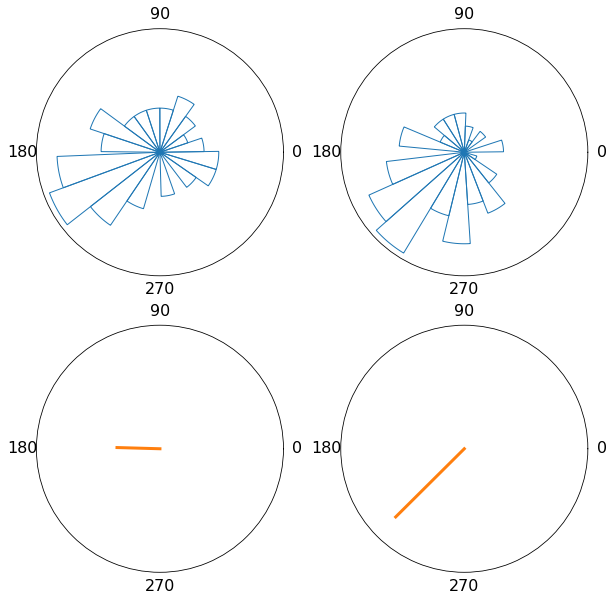

In [5]:
## EXAMPLE PLV FIGURE

# identify electrode A and E b
e_a_lbl = 'HUP087-22-23'
e_a_idx = np.flatnonzero(metadata_c3.uElbl.to_numpy()==e_a_lbl)[0]
E_A = mm_func.Electrode(EEG_c3[e_a_idx],metadata_c3[e_a_idx:e_a_idx+1])

e_b_lbl = 'HUP087-39-40'
e_b_idx = np.flatnonzero(metadata_c1.uElbl.to_numpy()==e_b_lbl)[0]
E_B = mm_func.Electrode(EEG_c1[e_b_idx],metadata_c1[e_b_idx:e_b_idx+1])

#  calc EEG, phase for each electrode
E_A.getEEG(params['event_type'],
                        params['time_window_ms_wave'],
                       params['buffer_ms_wave'],
                      params['rejection_thresh_sd'])
E_A.calcPhase(params['buffer_ms_wave'],params['frange_wave'],params['numfreqs_wave'])


E_B.getEEG(params['event_type'],
                        params['time_window_ms_wave'],
                       params['buffer_ms_wave'],
                      params['rejection_thresh_sd'])
E_B.calcPhase(params['buffer_ms_wave'],params['frange_wave'],params['numfreqs_wave'])


# calculate phase difference between Ea and Eb
E_A.calcPhaseDiff(E_B)

# Initialize figure
#fig = figure(figsize=[10,20])
fig, ax = subplots(2, 2,squeeze=False, subplot_kw=dict(projection='polar'),figsize=[10,10])

# calc PLV polar in pre-stim time win
E_A.calcPLV(params['theta_range'],params['time_window_ms_pre_plv'],usePhaseDiff=True)
#E_A.plotPLV_polar(subplot(1,2,1,polar = True))
rose_plot(ax[0,0], E_A.phs_avg,bins=20,density=False)
#ax[0,0].hist(E_A.phs_avg,30)
theta = circ.mean(E_A.phs_avg)
r = circ.resultant_vector_length(E_A.phs_avg)
ax[0,0].set_yticks([])
ax[0,0].set_xticks([deg2rad(0),deg2rad(90),deg2rad(180),deg2rad(270)])
ax[0,0].set_xticklabels(labels=[0,90,180,270],fontdict={'fontsize':16})
ax[0,0].grid(False)
ax[0,0].set_theta_direction(1)

ax[1,0].plot([0,theta],[0,r],linewidth = 3,color='C1')
ax[1,0].set_rlim([0,0.5])
ax[1,0].set_rticks([])
ax[1,0].set_xticks([deg2rad(0),deg2rad(90),deg2rad(180),deg2rad(270)])
ax[1,0].set_xticklabels(labels=[0,90,180,270],fontdict={'fontsize':16})
ax[1,0].grid(False)


print('RVL PRE = ',circ.resultant_vector_length(E_A.phs_avg))




E_A.calcPLV(params['theta_range'],params['time_window_ms_pst_plv'],usePhaseDiff=True)
rose_plot(ax[0,1],E_A.phs_avg,bins=20,density=False)
#E_A.plotPLV_polar(subplot(1,2,2,polar = True))
#ax[0,1].hist(E_A.phs_avg,30)
theta = circ.mean(E_A.phs_avg)
r = circ.resultant_vector_length(E_A.phs_avg)
ax[0,1].set_yticks([])
ax[0,1].set_xticks([deg2rad(0),deg2rad(90),deg2rad(180),deg2rad(270)])
ax[0,1].set_xticklabels(labels=[0,90,180,270],fontdict={'fontsize':16})
ax[0,1].grid(False)
ax[0,1].set_theta_direction(1)

ax[1,1].plot([0,theta],[0,r],linewidth = 3,color='C1')
ax[1,1].set_rlim([0,0.5])
ax[1,1].set_rticks([])
ax[1,1].set_xticks([deg2rad(0),deg2rad(90),deg2rad(180),deg2rad(270)])
ax[1,1].set_xticklabels(labels=[0,90,180,270],fontdict={'fontsize':16})
ax[1,1].grid(False)

print('Angle POST =',rad2deg(circ.mean(E_A.phs_avg)))
print('RVL POST = ',circ.resultant_vector_length(E_A.phs_avg))




savefig('figs/plv_example.pdf',dpi = 150)

72 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Effective window size : 0.500 (s)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 2.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is freq-res)
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

72 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Effective window size : 0.500 (s)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 2.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is freq-res)
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



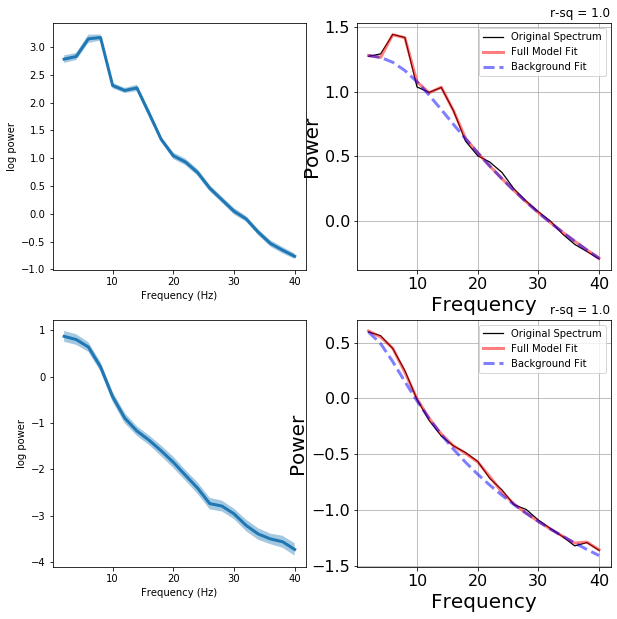

In [6]:
# plot PSD
fig,ax = subplots(2,2,squeeze=False,figsize=[10,10])


axes(ax[0,0])
E = E_A
E.getEEG(time_window_ms=
                    params['time_window_ms_pre'])
E.calcPSD(params['frange'])
E.plotPSD(ax=ax[0,0])
E.fitFOOOF()
#E.plotFOOOF_params(subplot(324),kol=C.colors[0])
E.plotFOOOF_fits(ax[0,1])



axes(ax[1,0])
E = E_B
E.getEEG(time_window_ms=
                    params['time_window_ms'])
E.calcPSD(params['frange'])
E.plotPSD(ax=ax[1,0])
E.fitFOOOF()
#E.plotFOOOF_params(subplot(324),kol=C.colors[0])
E.plotFOOOF_fits(ax[1,1])

axis('tight')
savefig('figs/psd_example.pdf',dpi = 150)


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 2.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is freq-res)
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 40 Hz                        
                                 Frequency Resolution is 2.00 Hz                                  
                                                                                                  
                          Background Parameters (offset, knee, slope): 

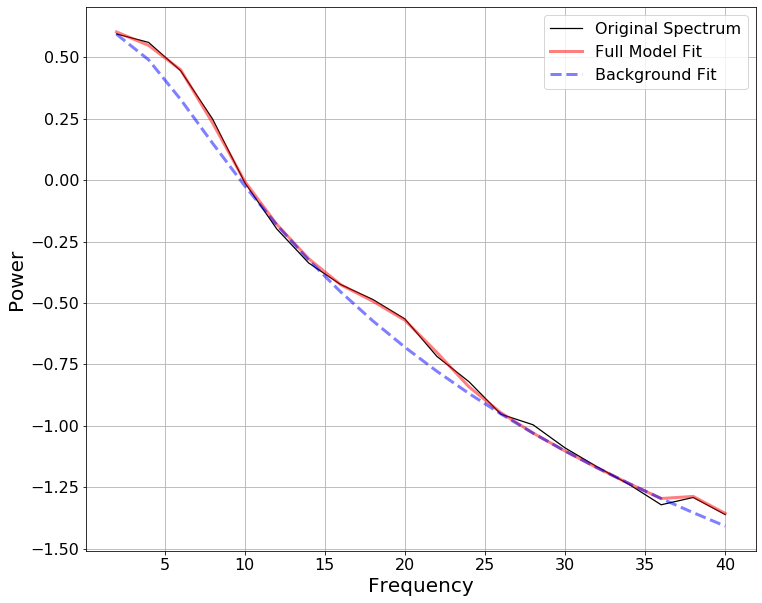

In [16]:
E_B.fm.report()

Setting up band-pass filter from 3 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 3.00, 8.00 Hz: -6.02, -6.02 dB

Setting up band-pass filter from 3 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 3.00, 8.00 Hz: -6.02, -6.02 dB



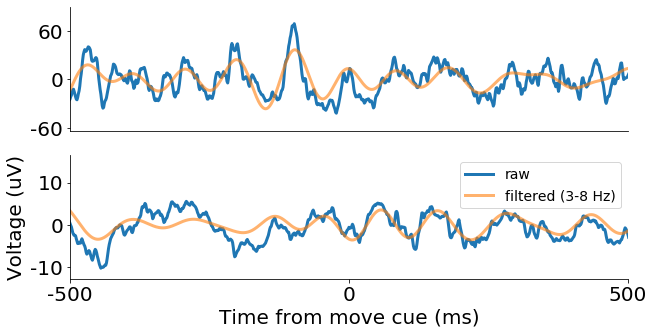

In [270]:
# Single trial example showing raw data from a single trial and filtered data 3-8 Hz

fig,ax = subplots(2,1,figsize=[10,5])
l_freq = 3
h_freq = 8
xl = [-500,500]
trialnum = 31

for trialnum in [31]:
    # E_A filtered
    axes(ax[0])
    E = E_A;
    samplerate = metadata_c3[e_a_idx:e_a_idx+1]['SR'].to_numpy()[0]
    eeg = E.eeg_clip.get_data()[trialnum].squeeze()
    eeg_filt = mne.filter.filter_data(eeg,sfreq=samplerate,l_freq=l_freq,h_freq=h_freq,method='iir');
    xval_s = np.linspace(E_A.time_window_ms[0],E_A.time_window_ms[1],np.shape(eeg_data)[0])
    plot(xval_s,eeg,linewidth=3)
    plot(xval_s,eeg_filt,linewidth=3,alpha=.6)
    ax[0].set_xlim(xl)
    ax[0].set_yticks([-60,0,60])
    ax[0].set_yticklabels(labels=[-60,0,60],fontdict={'fontsize':20})
    ax[0].set_xticks([])
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)

    # E_B filtered
    axes(ax[1])
    E = E_B;
    samplerate = metadata_c3[e_b_idx:e_b_idx+1]['SR'].to_numpy()[0]
    eeg = E.eeg_clip.get_data()[trialnum].squeeze()
    eeg_filt = mne.filter.filter_data(eeg,sfreq=samplerate,l_freq=l_freq,h_freq=h_freq,method='iir');
    xval_s = np.linspace(E_A.time_window_ms[0],E_A.time_window_ms[1],np.shape(eeg_data)[0])
    line_raw, = plot(xval_s,eeg,linewidth=3,label='raw')
    #line_raw.set_label()
    line_filt, = plot(xval_s,eeg_filt,linewidth=3,label='filtered (3-8 Hz)',alpha=.6)
    #line_filt.set_label('filtered (3-8 Hz)')
    ax[1].set_xlim(xl)
    ax[1].set_yticks([-10,0,10])
    ax[1].set_yticklabels(labels=[-10,0,10],fontdict={'fontsize':20})
    ax[1].set_xticks([-500,0,500])
    ax[1].set_xticklabels(labels=[-500,0,500],fontdict={'fontsize':20})
    ax[1].set_ylabel('Voltage (uV)',fontdict={'fontsize':20})
    ax[1].set_xlabel('Time from move cue (ms)',fontdict={'fontsize':20})
    ax[1].legend(fontsize=14)
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    
savefig('figs/single_trial_eg_HUP087_22-23_39-40.pdf',dpi = 150)

72 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Need more than one channel to make topography for ecog. Disabling interactivity.
72 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Effective window size : 0.500 (s)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 2.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is freq-res)
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

72 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Effective window size : 0.500 (s)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 2.00 <= 0.50
	Lower bounds below frequency-resolution

/Users/ashwinramayya/anaconda3/envs/environment_name/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/ashwinramayya/anaconda3/envs/environment_name/lib/python3.7/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/ashwinramayya/anaconda3/envs/environment_name/lib/python3.7/site-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWa

72 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
/Users/ashwinramayya/Dropbox/neurosurgery_research/data/scratch/clusStruct/pac/
/Users/ashwinramayya/Dropbox/neurosurgery_research/data/scratch/clusStruct/pac/pacClusStruct-3.mat
dict_keys(['__header__', '__version__', '__globals__', 'eegStruct_thisClus'])
Number of contacts in Cluster 3 = 46
REPLACING Contact 13 field anat with NONE
Done loading Cluster 3
72 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
72 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
72 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
72 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
72 mat

/Users/ashwinramayya/anaconda3/envs/environment_name/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/ashwinramayya/anaconda3/envs/environment_name/lib/python3.7/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/ashwinramayya/anaconda3/envs/environment_name/lib/python3.7/site-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWa

72 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
/Users/ashwinramayya/Dropbox/neurosurgery_research/data/scratch/clusStruct/pac/
/Users/ashwinramayya/Dropbox/neurosurgery_research/data/scratch/clusStruct/pac/pacClusStruct-3.mat
dict_keys(['__header__', '__version__', '__globals__', 'eegStruct_thisClus'])
Number of contacts in Cluster 3 = 46
REPLACING Contact 13 field anat with NONE
Done loading Cluster 3
72 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
72 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
72 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
72 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
72 mat

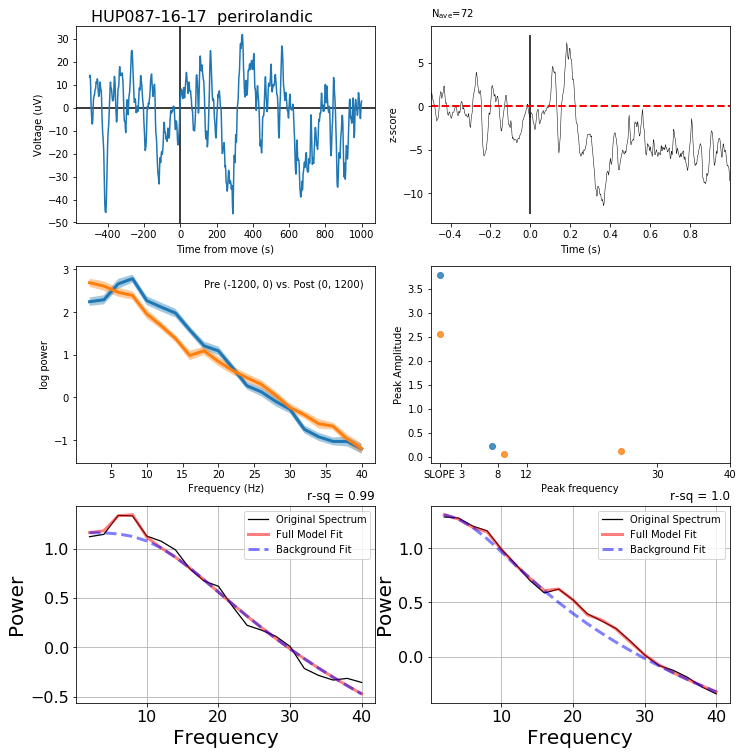

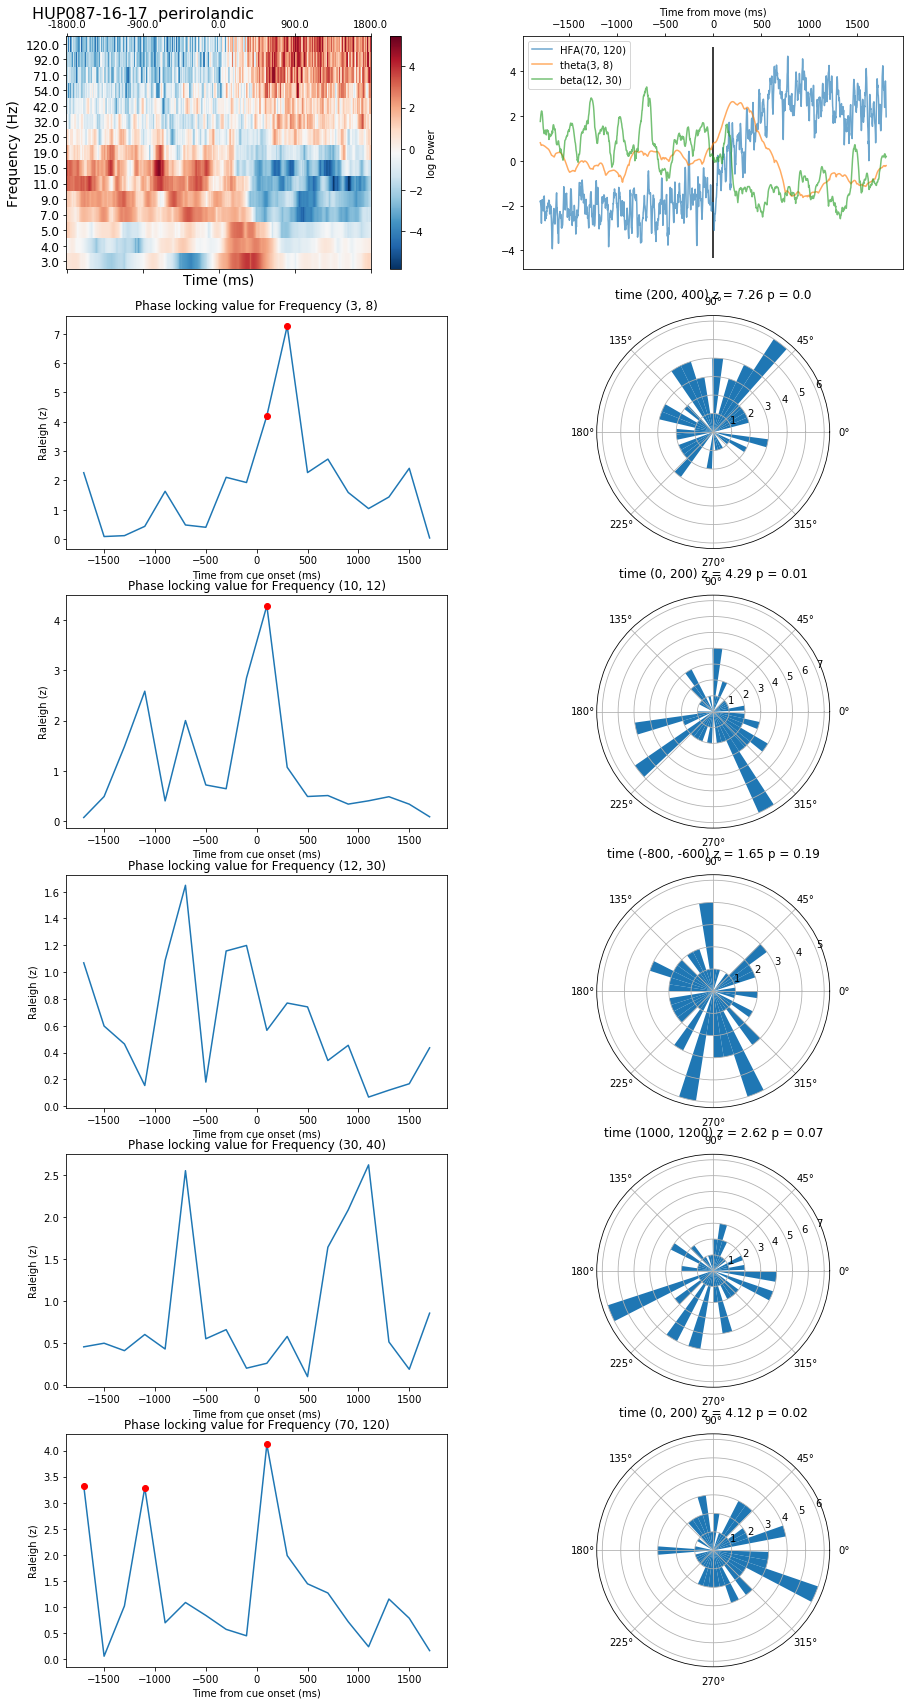

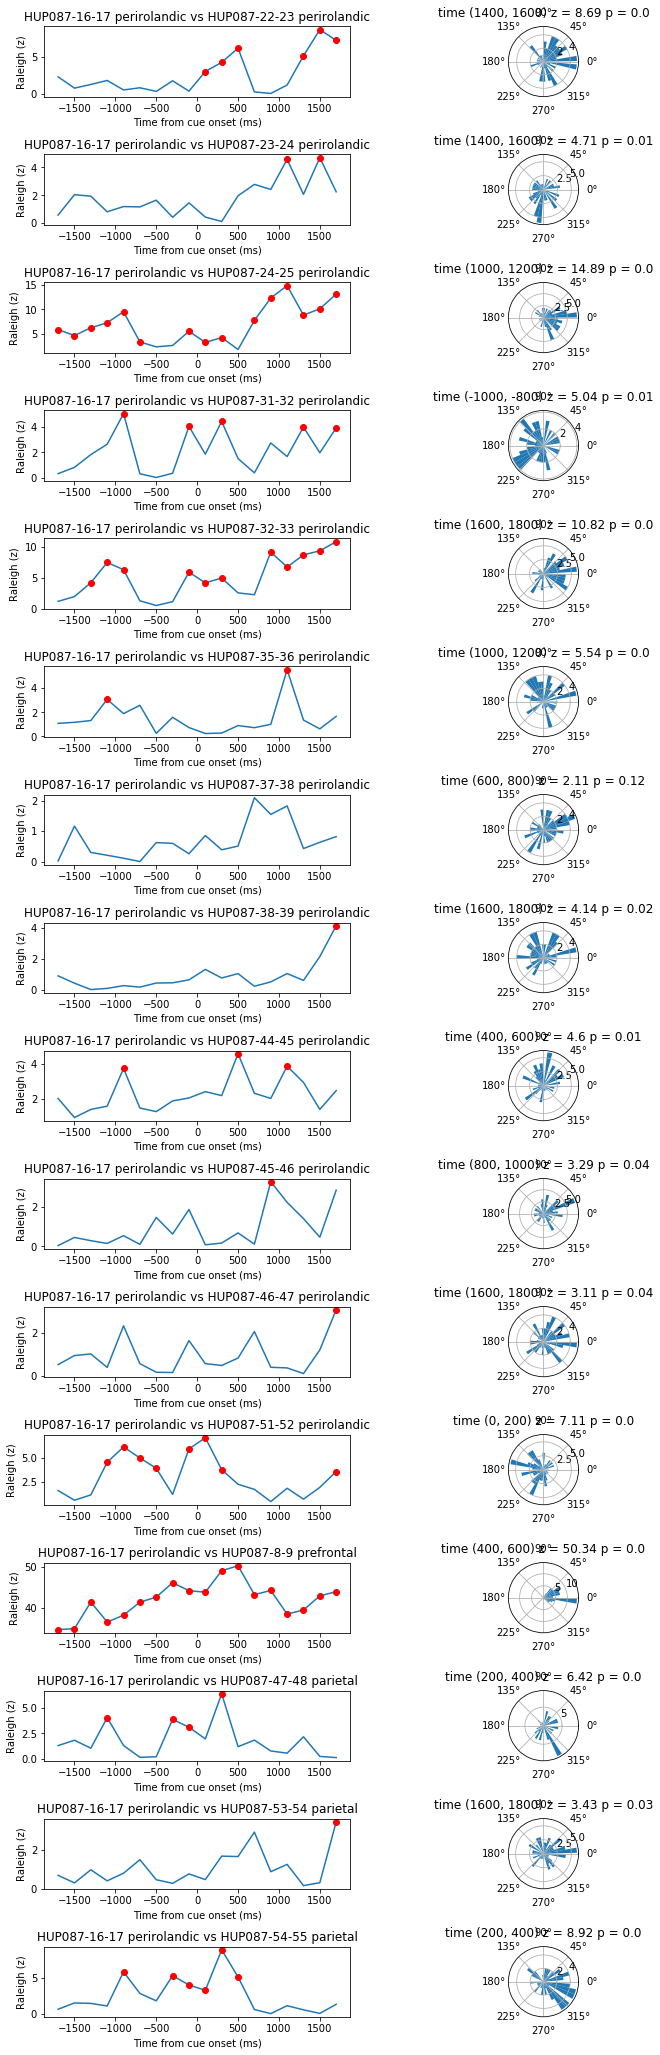

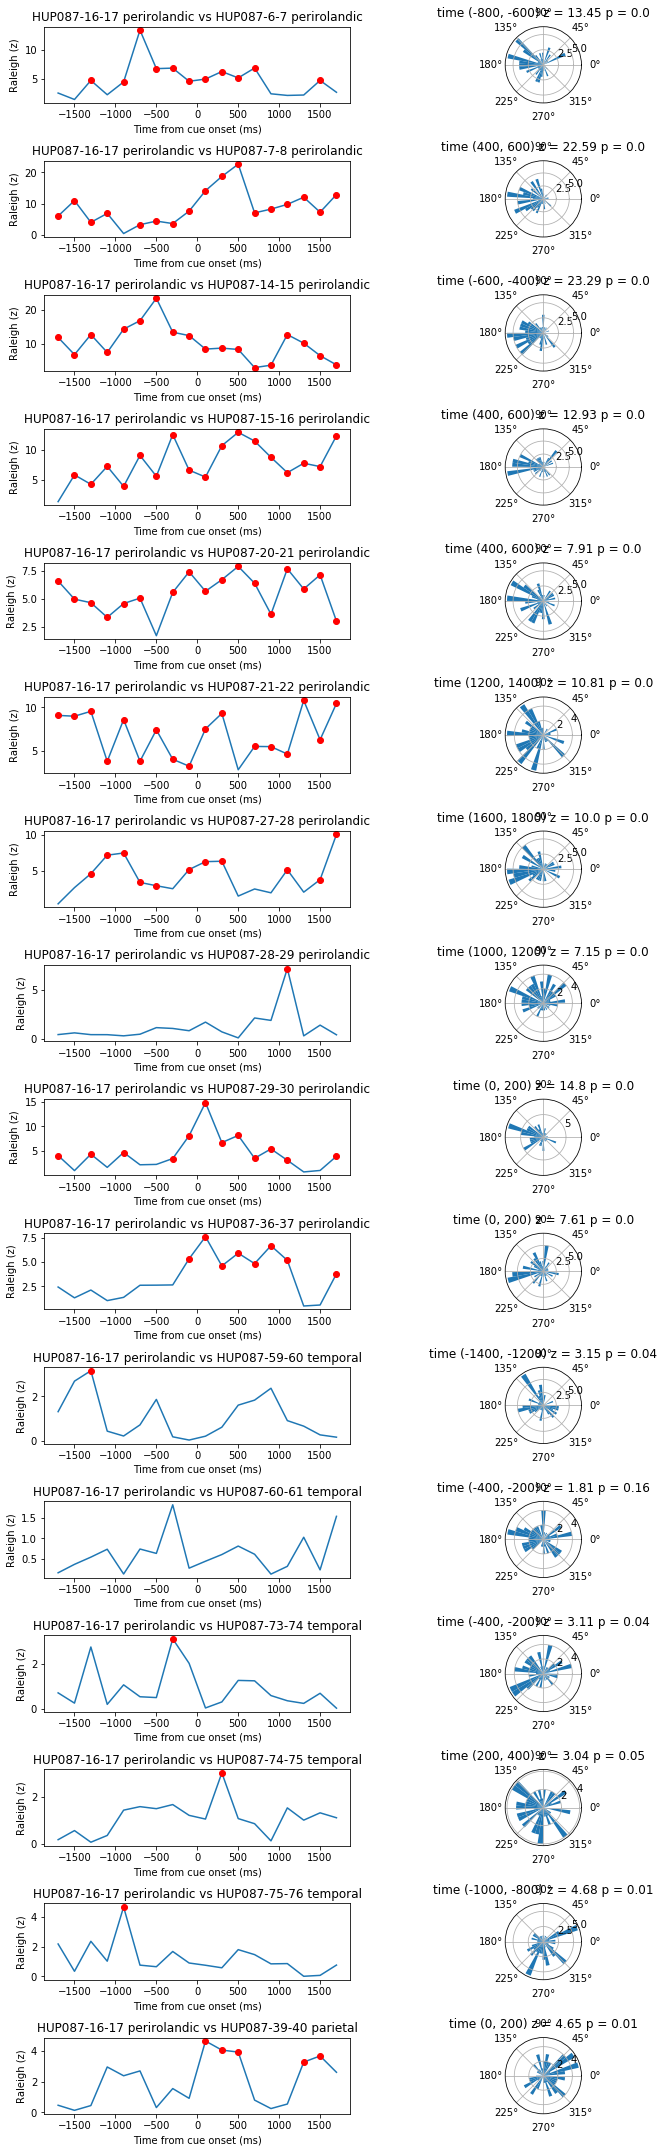

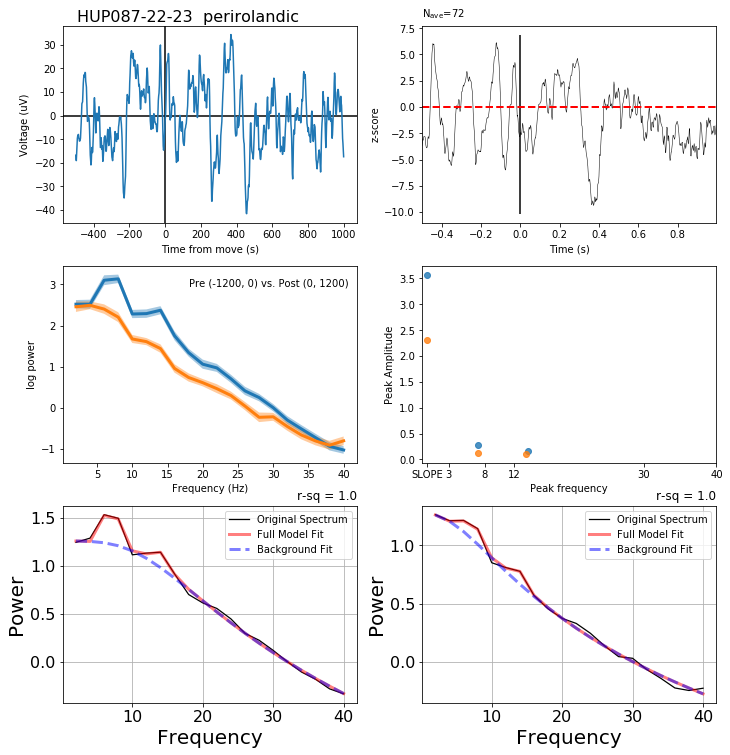

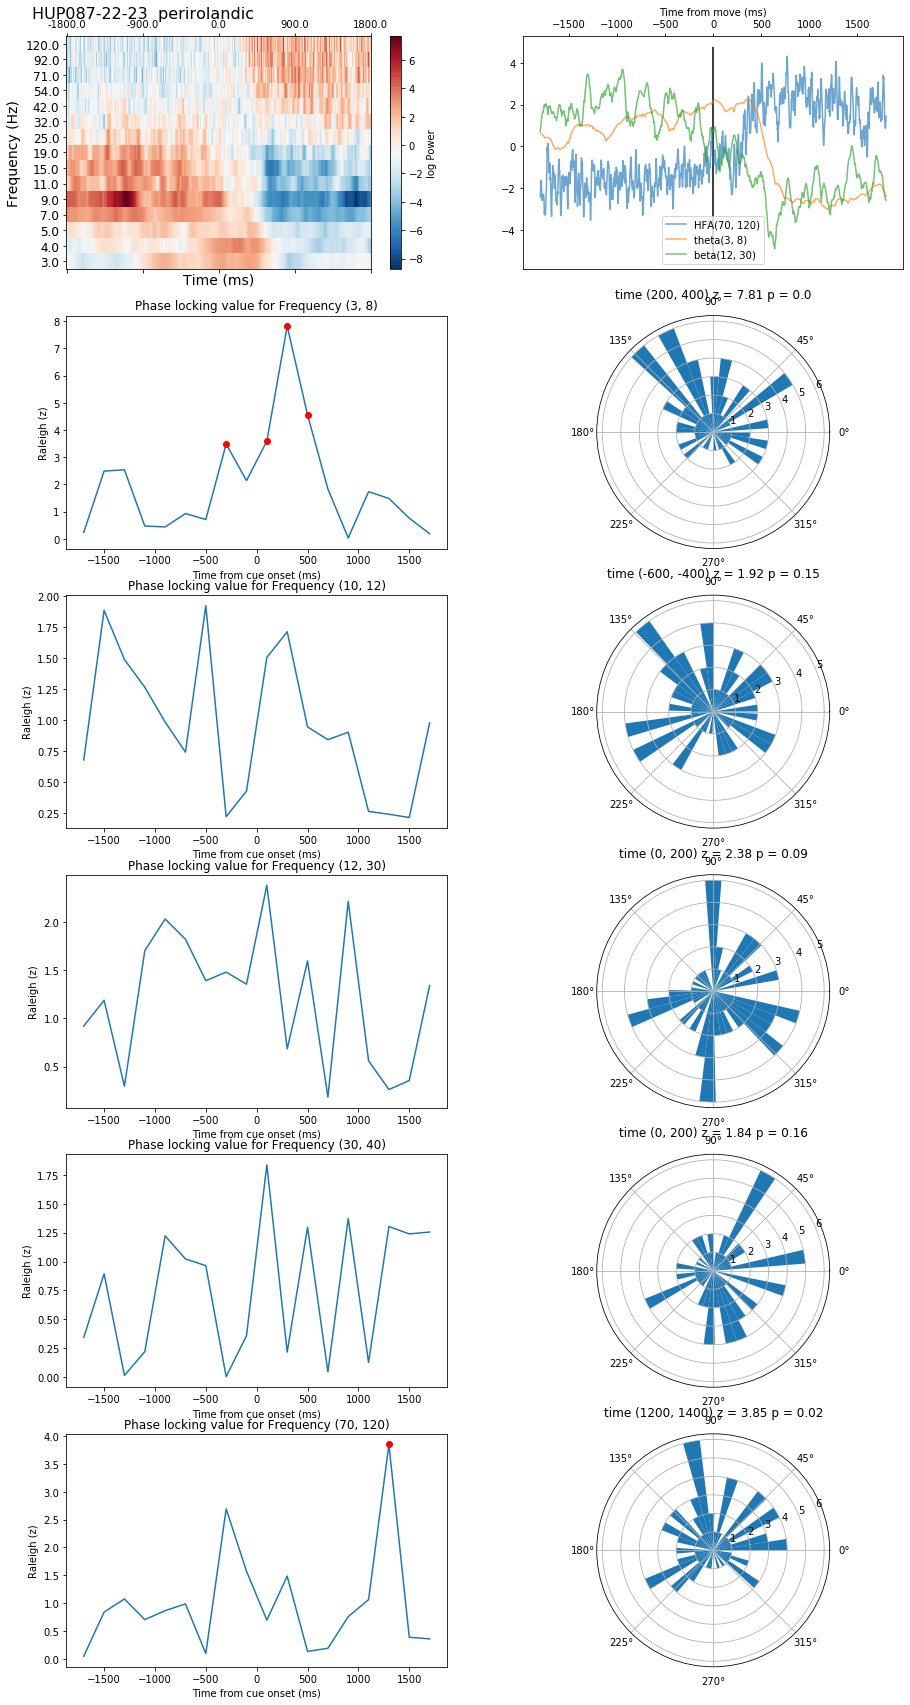

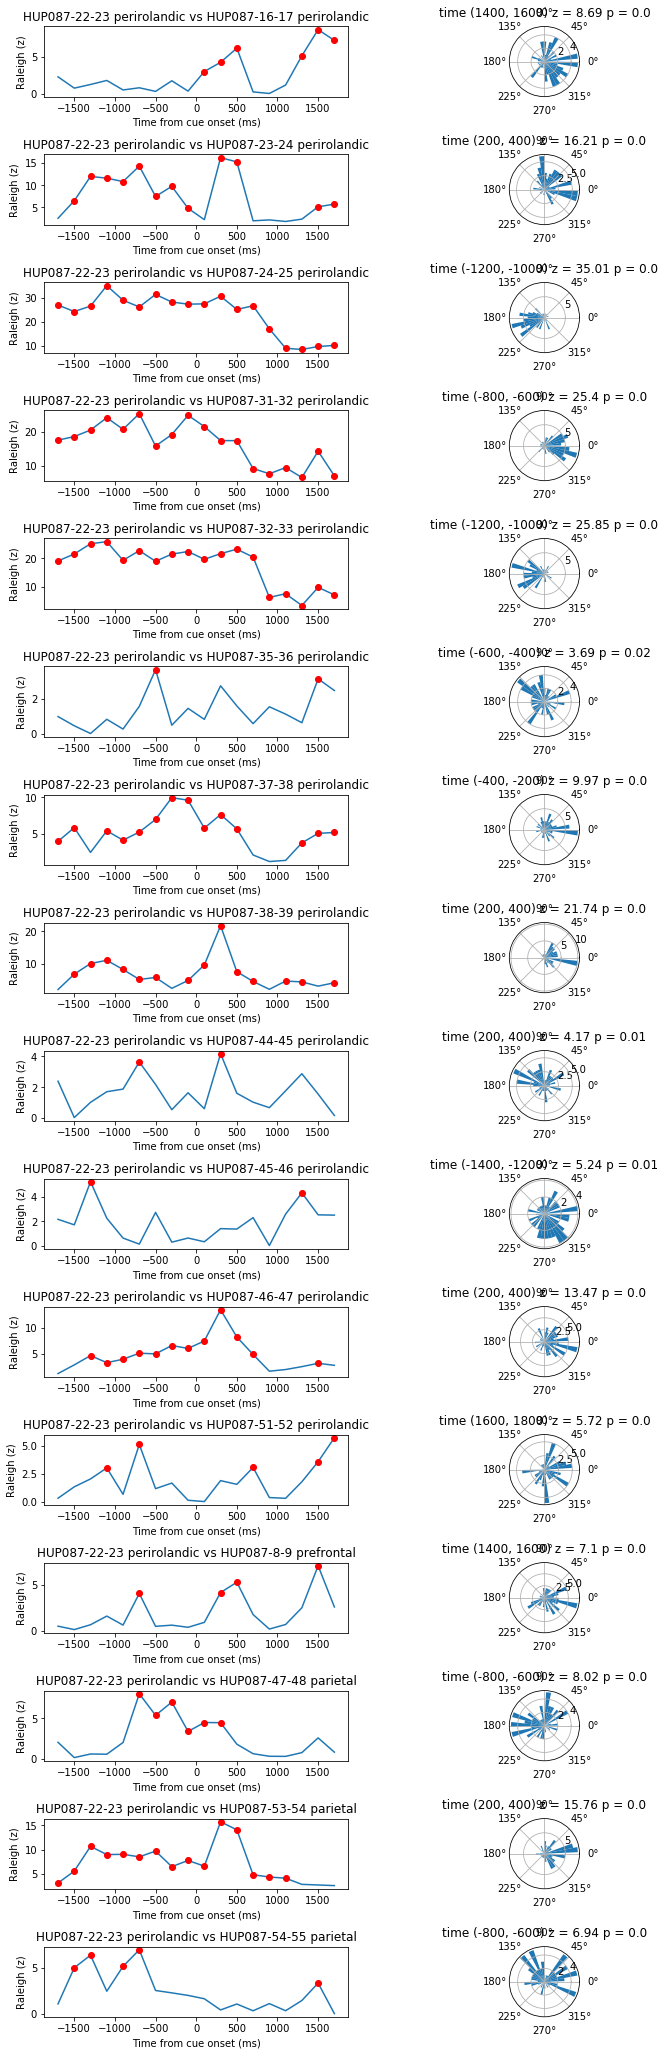

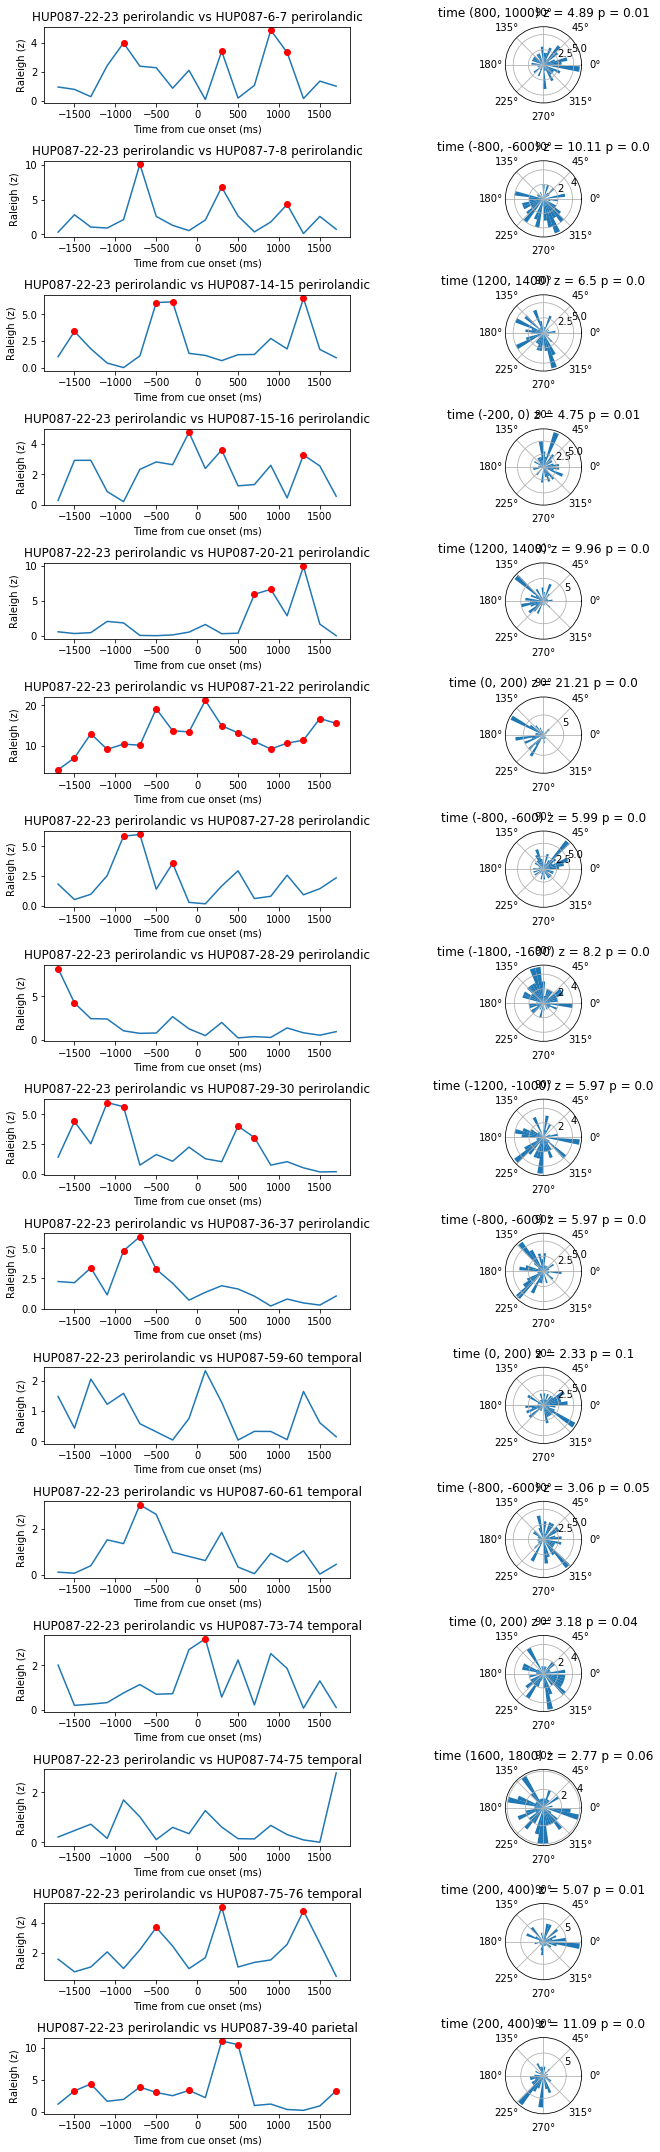

In [9]:
#%%capture
# loop through all electrodes in cluster and make a report 
for c in (0,1):#arange(0,len(EEG_masked)):
    #print(c)
    
    #Initialize fig name
    figname = figpath+metadata[c:c+1]['uElbl'].iloc[0]
    
    # initialize electrode
    E_A = mm_func.Electrode(EEG[c],metadata[c:c+1])
    
    # PSD summary
    plotPSDSummary_local(E_A,params)
    savefig(figname, bbox_inches = "tight")
    
    # TF summary 
    plotTFSummary_local(E_A,params)
    savefig(figname+'TF', bbox_inches = "tight")
    
    # PLV vs. cluster 3
    plotPLVSummary_local(E_A,params,3)
    savefig(figname+'vsC3', bbox_inches = "tight")
    
    # PLV vs. cluster 1
    plotPLVSummary_local(E_A,params,1)
    savefig(figname+'vsC1', bbox_inches = "tight")